# Dev for using mga1dsm within Saturnian system

In [1]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [3]:
spice.furnsh(os.path.join(os.environ["SPICE"], "lsk", "naif0012.tls"))
spice.furnsh(os.path.join(os.environ["SPICE"], "spk", "cg_1950_2050_v03.bsp"))

In [4]:
et = spice.utc2et("2044-01-01T00:00:00")
saturn_sv = spice.spkssb(699, et, "ECLIPJ2000")
titan_sv = spice.spkssb(606, et, "ECLIPJ2000")

r_titan_sat = titan_sv[0:3] - saturn_sv[0:3]
v_titan_sat = titan_sv[3:6] - saturn_sv[3:6]

In [5]:
np.linalg.norm(v_titan_sat)

5.5848822304981445

In [6]:
pxp.MU_SATURN

3.79405852e+16

In [7]:
pk.ic2par(r_titan_sat*1e3, v_titan_sat*1e3, pxp.MU_SATURN)

(1221914042.5450587,
 0.028659655999962765,
 0.48280065937311095,
 2.949265038410724,
 3.2731913085559383,
 1.491791176502704)

### Construct Saturn system

In [8]:
saturn_system_list = pxp.saturn_system()
saturn_system_list

{'titan': Planet Name: titan
 Own gravity parameter: 8978138845307.375
 Central body gravity parameter: 37940585200000000
 Planet radius: 2575000
 Planet safe radius: 3575000
 Keplerian planet elements: 
 Semi major axis (AU): 0.0081679908738070735
 Eccentricity: 0.028659655999962765
 Inclination (deg.): 27.662440128212527
 Big Omega (deg.): 168.9804393664231
 Small omega (deg.): 187.54004751915846
 Mean anomaly (deg.): 85.473338328460613
 Elements reference epoch: 2044-Jan-01 00:00:00
 Ephemerides type: Keplerian
 r at ref. = [74005909.532861978, 1079935558.3067718, -563053636.82884848]
 v at ref. = [-5536.0208448477342, 669.44868825434207, 210.2324367740141]}

In [9]:
n_rev = 1
seq = [saturn_system_list["titan"] for el in range(n_rev+1)]

In [10]:
titan_period = saturn_system_list["titan"].compute_period(epoch(2345.3, 'mjd2000')) / 86400  # days
titan_period

15.946856899173898

In [11]:
tof = [
    [0.75*titan_period, 1.5*titan_period] for el in range(len(seq)-1)
]

t0_earliest = pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000
t0_latest   = pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000
    
t0 = [
    t0_earliest,
    t0_latest,
]

In [12]:
tof

[[11.960142674380425, 23.92028534876085]]

In [13]:
R_incoming, _ = saturn_system_list["titan"].eph(t0_earliest)
vinf_incoming = np.sqrt(2*pxp.MU_SATURN/np.linalg.norm(R_incoming))  # escape velocity w.r.t. Saturn system at Titan orbit

In [14]:
vinf_incoming

7886.064430152493

In [15]:
prob_titan = pxp.mga_1dsm_fixed_vexcess(
    seq = seq,
    t0 = t0,                          
    tof = tof,
    vinf = [0.0, 0.0],  # starting v-infinity is fixed, and is in km/s!!!
    multi_objective = False, 
    add_vinf_dep = False, 
    add_vinf_arr = True,
    tof_encoding = 'direct',
    vexcess=vinf_incoming,
)

In [16]:
algo = pg.algorithm(pg.sade(
    gen=10,
))

In [17]:
pop_size = 10

pop = pg.population(prob=prob_titan, size=pop_size)
pop = algo.evolve(pop)

In [20]:
pop.champion_f

array([14181.17232933])

In [18]:
prob_titan.pretty(pop.champion_x)

First Leg: titan to titan
Departure: 2044-Jan-01 00:00:00 (16071.0 mjd2000) 
Duration: 13.292584756158284days
VINF: 0.0 km/sec
DSM after 1.8762590609702194 days
DSM magnitude: 1.076128643599007e-11m/s

Arrival at titan
Arrival epoch: 2044-Jan-14 07:01:19.322932 (16084.292584756158 mjd2000) 
Arrival Vinf: 9.151613902530748e-12m/s
Total mission time: 0.03639311363766813 years (13.292584756158284 days)


<IPython.core.display.Javascript object>


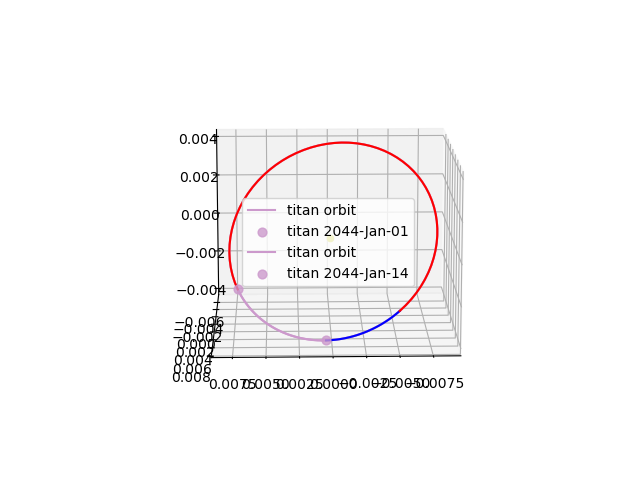

In [19]:
prob_titan.plot(pop.champion_x)
plt.show()